Checking whether dark dresses could be observed at earth-based interferometers.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import os
from typing import Callable, Dict, Tuple

import jax
import jax.numpy as jnp
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar, root_scalar
from tqdm.auto import tqdm

from pydd.analysis import *
from pydd.binary import *
from pydd.noise import *

rho_s_pbh = 1.798e4 * MSUN / PC ** 3
gamma_s_pbh = 9 / 4

2022-01-19 11:12:18.623767: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-19 11:12:18.624258: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


## Setup

Check how characteristic strain of signal scales with frequency compared to noise. (See sec. 2.2 of [this paper](https://arxiv.org/pdf/1408.0740.pdf) for its definition.)

In [2]:
def get_fl_ttoh(m_1, m_2, rho_6, gamma_s, f_range, t_to_h_max):
    _dd = make_dynamic_dress(m_1, m_2, rho_6, gamma_s, dL=100e6 * PC)  # dL irrelevant
    f_h = min(_dd.f_c, f_range[1])
    get_t_to_h = lambda f_l: t_to_c(f_l, _dd) - t_to_c(f_h, _dd)
    res = minimize_scalar(
        lambda f_l: (get_t_to_h(f_l) - t_to_h_max) ** 2,
        bounds=(f_range[0], 0.999 * f_h),
        method="bounded",
    )
    assert res.success, res
    f_l = res.x
    t_to_h = get_t_to_h(f_l)
    return f_l, t_to_h


def get_dL(m_1, m_2, rho_6, gamma_s, S_n, f_l, f_h, snr_thresh):
    fs_snr = jnp.linspace(f_l, f_h, 1000)

    def fun(x):
        dd = make_dynamic_dress(m_1, m_2, rho_6, gamma_s, dL=x)
        return calculate_SNR(dd, fs_snr, S_n) - snr_thresh

    res = root_scalar(fun, bracket=(0.1e6 * PC, 100000e6 * PC))
    assert res.converged
    return res.root


def fit_v(dd, S_n, fs, pad_low, pad_high):
    def fun(x):
        vb = VacuumBinary(x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
        nll = -loglikelihood_fft(vb, dd, fs, pad_low, pad_high, S_n)
        return nll

    bracket = (dd.M_chirp / MSUN, dd.M_chirp / MSUN * (1 + 5e-3))
    res = minimize_scalar(fun, bracket=bracket)  # , tol=1e-100)
    assert res.success
    return VacuumBinary(res.x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)

In [3]:
def get_statistics(
    m_1: float,
    m_2: float,
    S_n: Callable[[jnp.ndarray], jnp.ndarray],
    f_range: Tuple[float, float],
    rho_s: float = rho_s_pbh,
    gamma_s: float = gamma_s_pbh,
    snr_thresh: float = 12,
    t_to_h_max: float = 1 * YR,
) -> Dict[str, jnp.ndarray]:
    """
    Computes statistcs for dark dresses around PBHs.

    Arguments
    - m_1, m_2: black hole masses [kg].
    - S_n: noise PSD.
    - f_range: support of S_n.
    - rho_6, gamma_s: initial spike parameters [kg / m^3, 1]. Default to PBH ones.
    - snr_thresh: target SNR. Used to compute distance to binary.
    - t_to_h_max: max duration for which signal can be measured [s].

    Returns
    A dict with the following entries:
    - dL: distance such that the system has the target SNR.
    - f_h: the smaller of max(f_range) and the binary's chirp frequency.
    - t_to_h: the time the system spends in band/before merging.
    - N_to_h: the number of GW cycles while the system is in band/before merging
    - dN_naive: dephasing between system with and without dress between
      `f_range[0]` and `f_h`.
    - dN: dephasing between dark dress and best-fit vacuum system between
      `f_range[0]` and `f_h`.
    - M_chirp_MSUN: dark dress' chirp mass [MSUN].
    - M_chirp_MSUN_v: best-fit vacuum binary's chirp mass [MSUN].
    - snr_loss_frac: fraction of SNR lost by using vacuum template to search
      for the dark dress.
    """
    result = defaultdict(lambda: jnp.nan)
    if m_2 / m_1 > 10 ** (-2.5):
        return result
    
    rho_6 = get_rho_6(rho_s, m_1, gamma_s)
    f_l, result["t_to_h"] = get_fl_ttoh(m_1, m_2, rho_6, gamma_s, f_range, t_to_h_max)
    f_h = min(get_f_isco(m_1), f_range[1])
    result["f_l"] = f_l
    result["f_h"] = f_h

    result["dL"] = get_dL(m_1, m_2, rho_6, gamma_s, S_n, f_l, f_h, snr_thresh)

    dd = make_dynamic_dress(m_1, m_2, rho_6, gamma_s, dL=result["dL"])
    vb_0 = convert(dd, VacuumBinary)

    # Basic information
    result["M_chirp_MSUN"] = dd.M_chirp / MSUN
    result["t_to_h"] = t_to_c(f_l, dd) - t_to_c(f_h, dd)
    result["N_to_h"] = (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd)) / (2 * pi)
    result["dN_naive"] = (
        Phi_to_c(f_l, vb_0)
        - Phi_to_c(f_h, vb_0)
        - (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd))
    ) / (2 * pi)

    # Fit vacuum system
    fs = jnp.linspace(f_l, f_h, 10000)
    pad_low, pad_high = get_match_pads(fs)
    vb = fit_v(dd, S_n, fs, pad_low, pad_high)
    result["M_chirp_MSUN_v"] = vb.M_chirp / MSUN
    result["dN"] = (
        Phi_to_c(f_l, vb) - Phi_to_c(f_h, vb) - (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd))
    ) / (2 * pi)

    result["snr"] = snr_thresh  # redundant
    match = calculate_match_unnormd_fft(vb, dd, fs, pad_low, pad_high, S_n)
    result["snr_loss_frac"] = jnp.clip(
        (result["snr"] - jnp.sqrt(match)) / result["snr"], 0
    )

    return result

## Run analysis

In [4]:
path = "et"
detector = path.split("-")[0]

In [ ]:
m_1_g = jnp.geomspace(1 * MSUN, 100 * MSUN, 40)
m_2_g = jnp.geomspace(1e-3 * MSUN, 5e-1 * MSUN, 38)
m_1_mg, m_2_mg = jnp.meshgrid(m_1_g, m_2_g)
m_1s, m_2s = m_1_mg.flatten(), m_2_mg.flatten()
f_range = eval(f"f_range_{detector}")
S_n = eval(f"S_n_{detector}")

results = []
for (m_1, m_2) in tqdm(list(zip(m_1s, m_2s))):
    results.append(get_statistics(m_1, m_2, S_n, f_range))

results = {
    k: jnp.array([r[k] for r in results]).reshape((len(m_2_g), len(m_1_g)))
    for k in results[0]
}

In [64]:
# jnp.savez(f"outputs/{path}.npz", m_1_mg=m_1_mg, m_2_mg=m_2_mg, **results)

## Plot!
Change the cell below as well as the contour levels to whatever you want.

In [65]:
# path = "aLIGO"
# detector = path.split("-")[0]

# # Load
# results = {k: jnp.array(v) for k, v in dict(jnp.load(f"outputs/{path}.npz")).items()}
# m_1_g = results.pop("m_1_mg")[0]
# m_2_g = results.pop("m_2_mg")[:, 0]
# m_1_mg, m_2_mg = jnp.meshgrid(m_1_g, m_2_g)

# Contour levels
aLIGO_levels = {
    "M_chirp_err": jnp.linspace(0, 0.002, 11),
    "snr_loss_frac": jnp.linspace(0, 40, 9),
    "dL": jnp.linspace(0, 300, 11),
    "t_in_band": jnp.geomspace(1e-2, 1e3, 5),
}
ce_levels = {
    "M_chirp_err": jnp.linspace(0, 0.005, 11),
    "snr_loss_frac": jnp.linspace(0, 80, 9),
    "dL": jnp.linspace(0, 20e3, 11),
    "t_in_band": jnp.geomspace(1e-2, 1e3, 5),
}
et_levels = {
    "M_chirp_err": jnp.linspace(0, 0.005, 11),
    "snr_loss_frac": jnp.linspace(0, 80, 9),
    "dL": jnp.linspace(0, 7e3, 9),
    "t_in_band": jnp.geomspace(1e0, 1e3, 5),
}

levels = eval(f"{detector}_levels")

if detector == "et":
    title = "Einstein Telescope"
elif detector == "ce":
    title = "Cosmic Explorer"
elif detector == "aLIGO":
    title = "aLIGO"

<ipython-input-66-1ba7b178a083>:14: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(


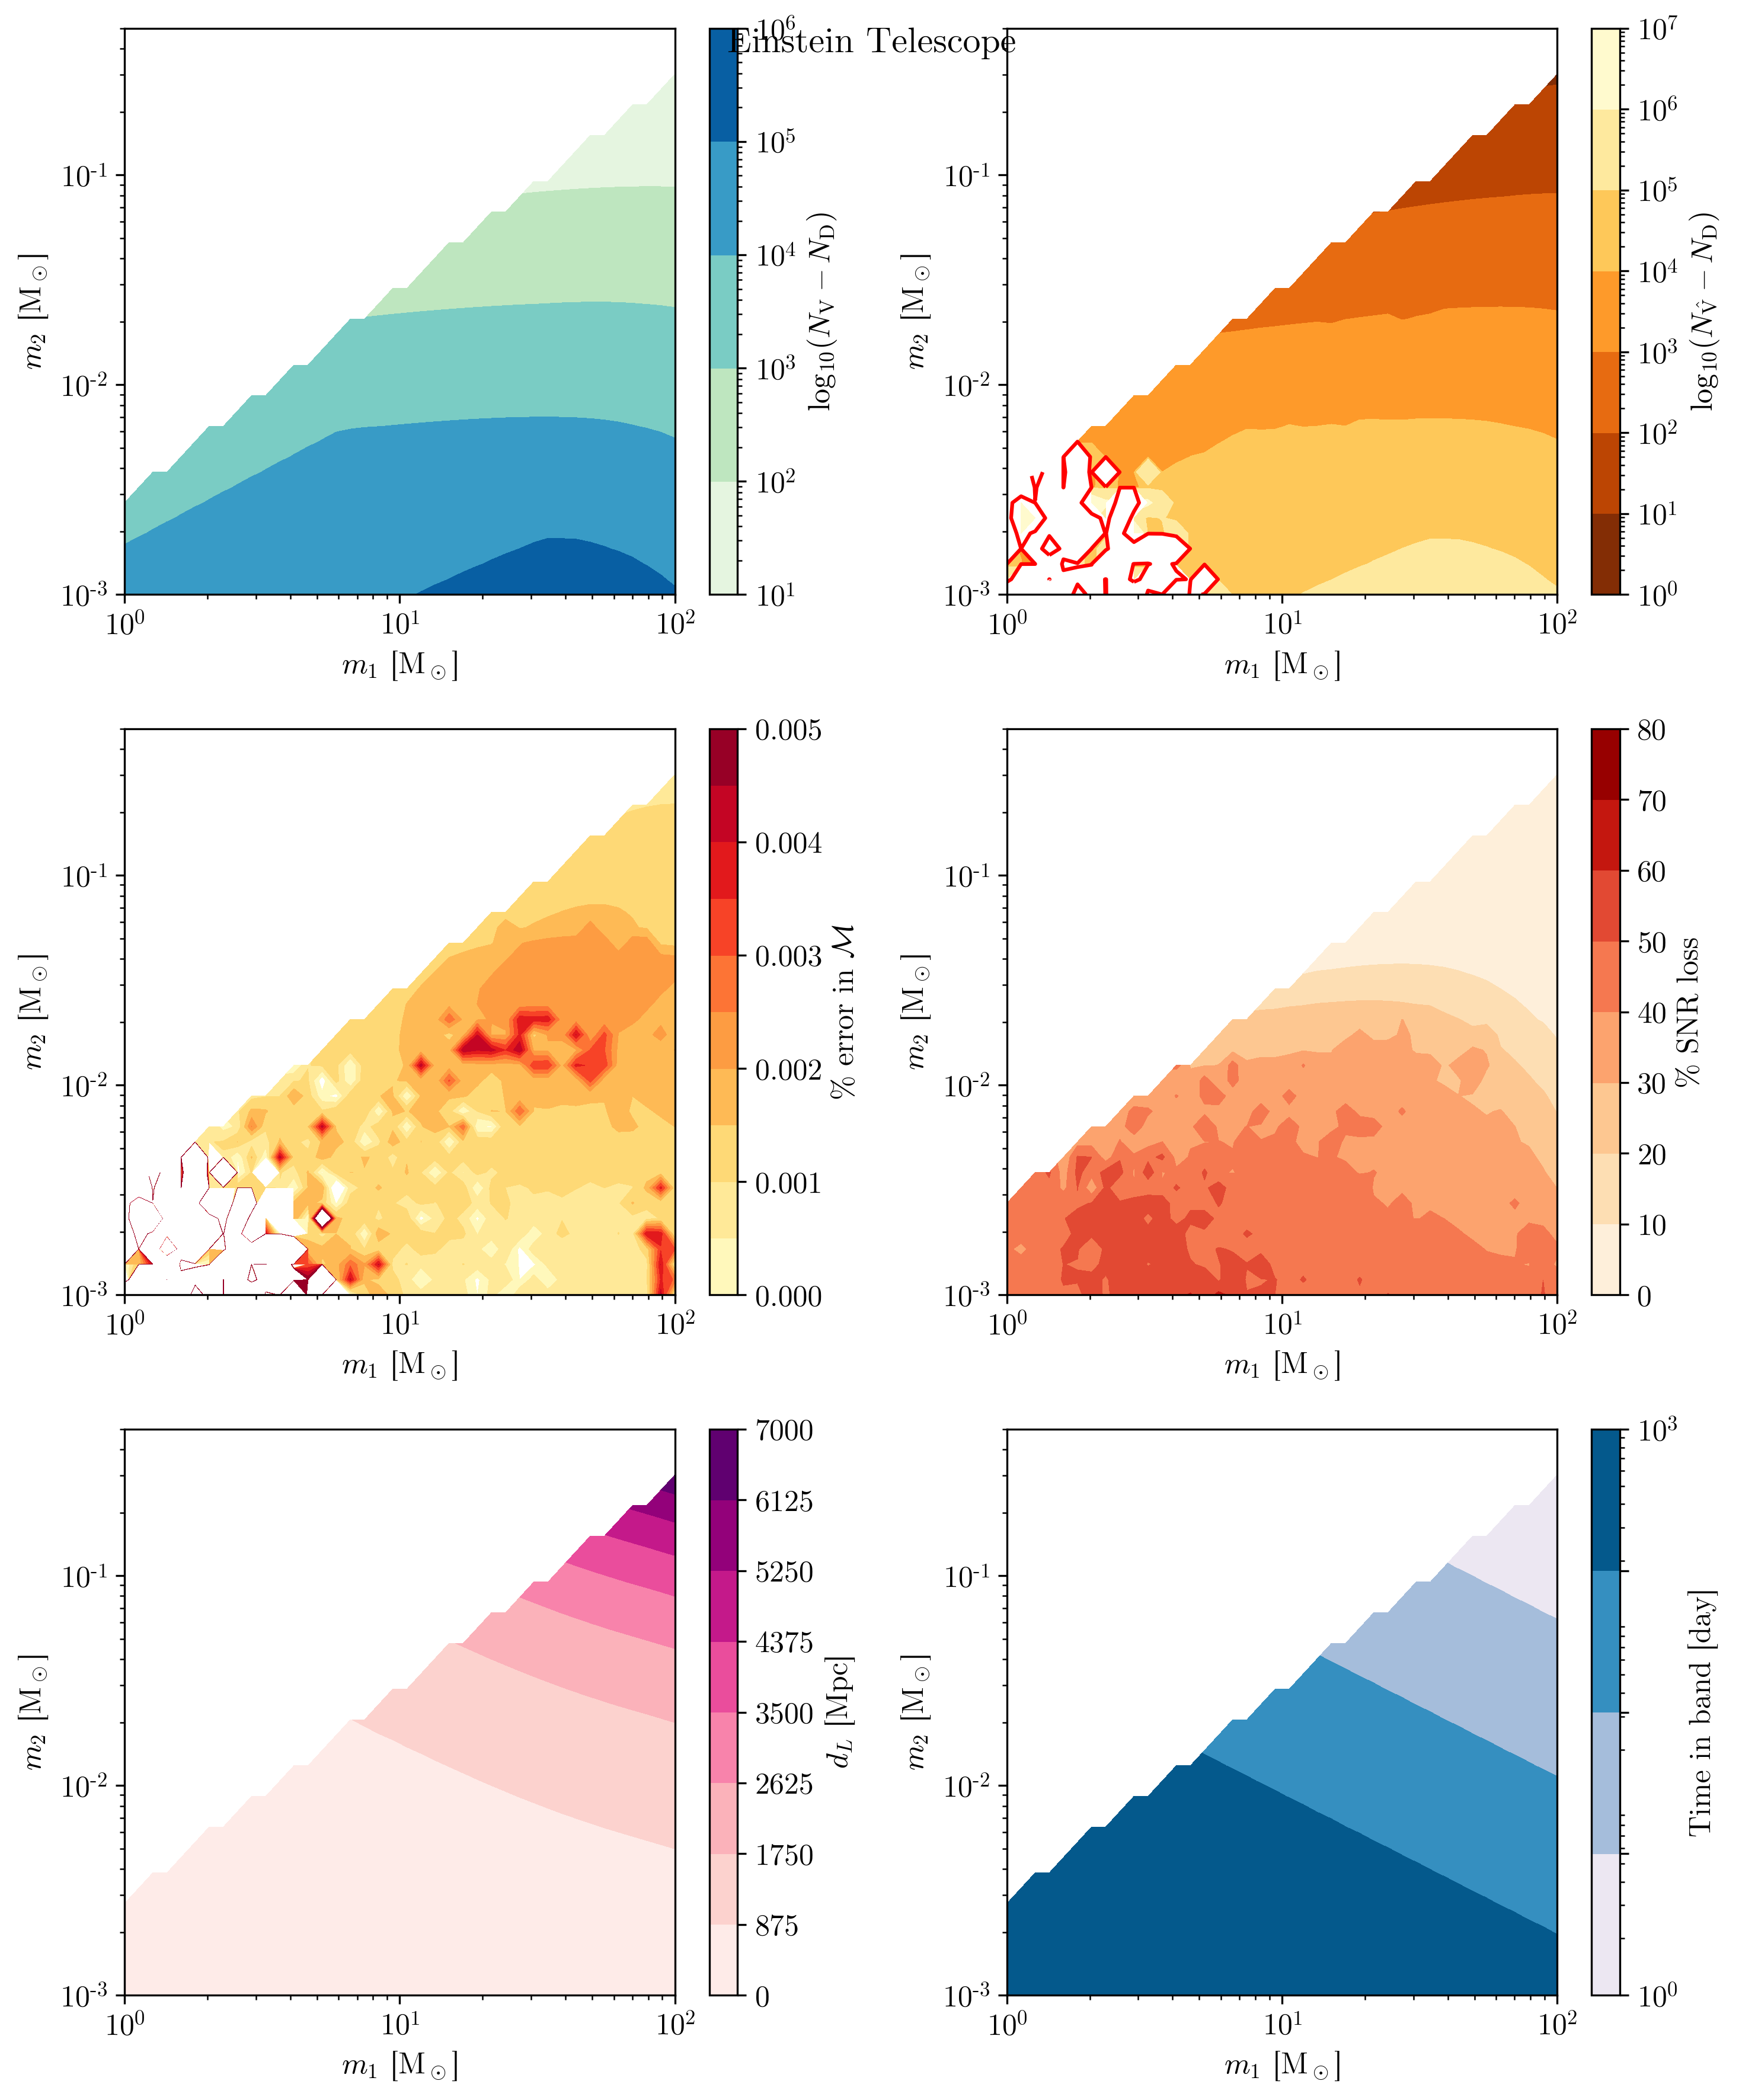

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

ax = axes[0, 0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["dN_naive"],
    locator=ticker.LogLocator(),
    cmap="GnBu",
)
plt.colorbar(cs, ax=ax, label=r"$\log_{10} (N_\mathrm{V} - N_\mathrm{D})$")

ax = axes[0, 1]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["dN"],
    locator=ticker.LogLocator(),
    cmap="YlOrBr_r",
)
plt.colorbar(cs, ax=ax, label=r"$\log_{10} (N_\hat{\mathrm{V}} - N_\mathrm{D})$")
ax.contour(m_1_g / MSUN, m_2_g / MSUN, results["dN"], [1], colors=["r"])

ax = axes[1, 0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    (results["M_chirp_MSUN_v"] - results["M_chirp_MSUN"])
    / results["M_chirp_MSUN"]
    * 100,
    levels=levels["M_chirp_err"],
    cmap="YlOrRd",
)
plt.colorbar(cs, ax=ax, label=r"% error in $\mathcal{M}$")

ax = axes[1, 1]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["snr_loss_frac"] * 100,
    levels=levels["snr_loss_frac"],
    cmap="OrRd",
)
plt.colorbar(cs, ax=ax, label="% SNR loss")

ax = axes[2, 0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["dL"] / (1e6 * PC),
    levels=levels["dL"],
    cmap="RdPu",
)
plt.colorbar(cs, ax=ax, label=r"$d_L$ [Mpc]")

ax = axes[2, 1]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["t_to_h"] / (24 * 60**2),
    cmap="PuBu",
#     levels=jnp.linspace(0, 2e3, 11),
    levels=levels["t_in_band"],
    locator=ticker.LogLocator(),
)
plt.colorbar(cs, ax=ax, label="Time in band [day]")

for ax in axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$m_1$ [M$_\odot$]")
    ax.set_ylabel(r"$m_2$ [M$_\odot$]")

fig.tight_layout()
fig.suptitle(title)
plt.savefig(f"figures/{path}.pdf")

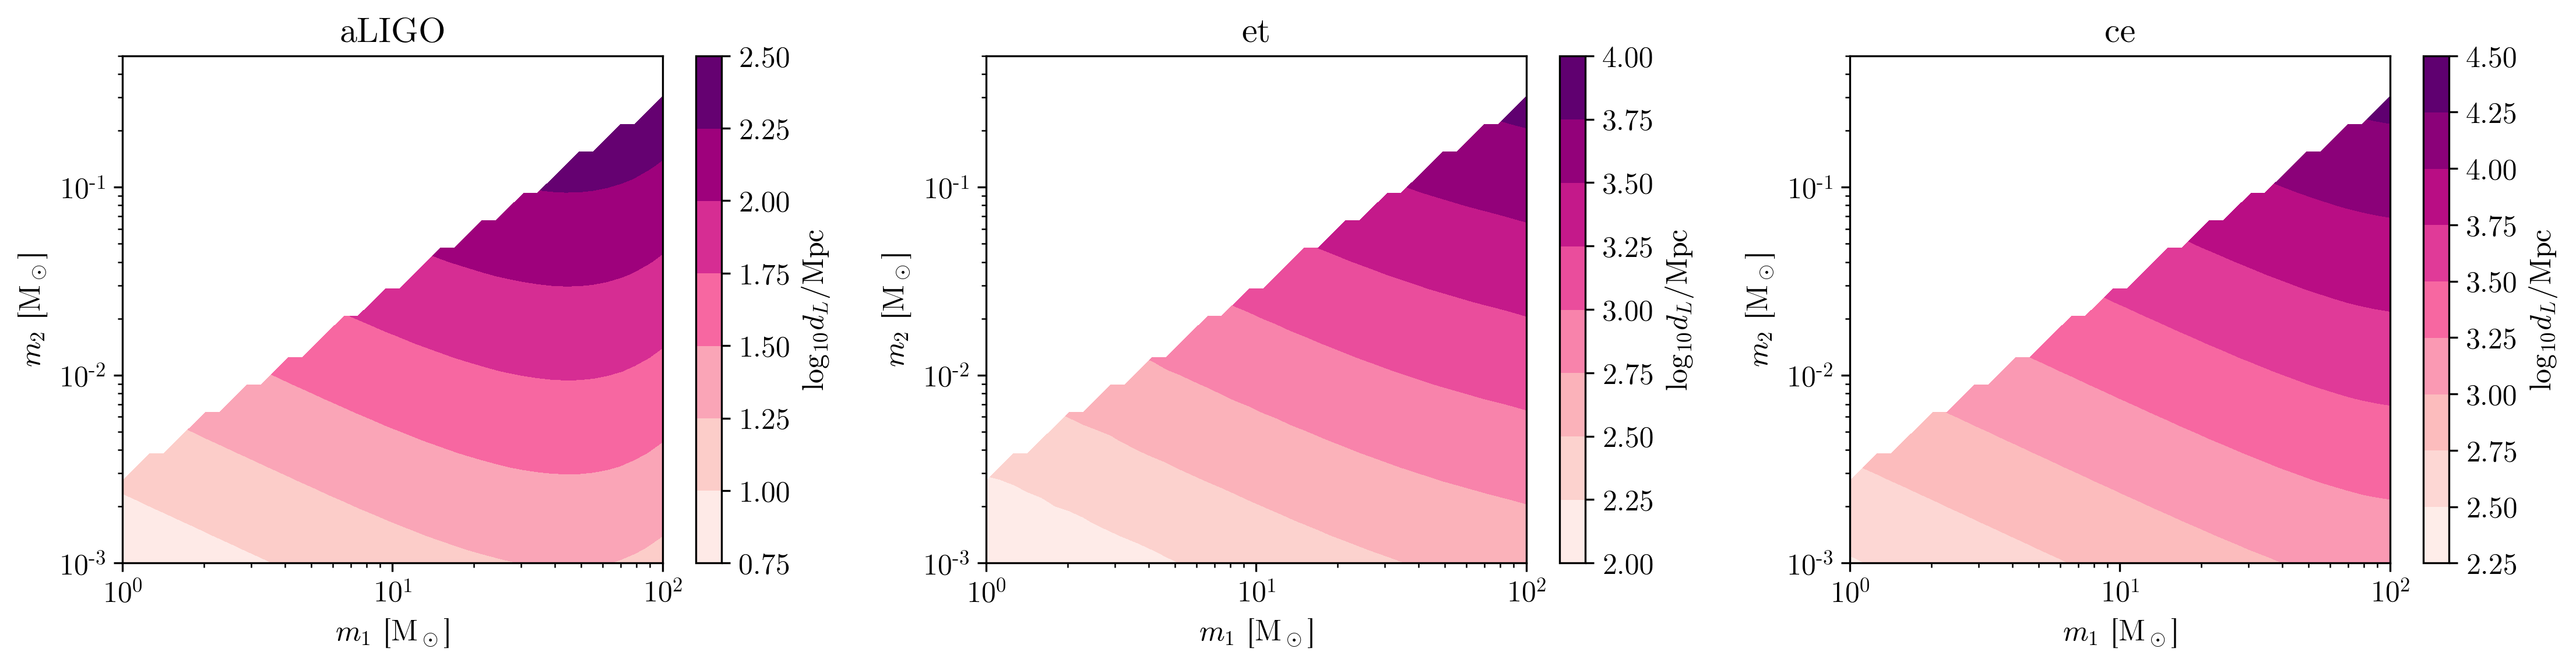

In [67]:
# Distances at which systems are detectable
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, telescope in zip(axs, ["aLIGO", "et", "ce"]):
    results = {
        k: jnp.array(v) for k, v in dict(jnp.load(f"outputs/{telescope}.npz")).items()
    }
    cs = ax.contourf(
        m_1_g / MSUN,
        m_2_g / MSUN,
        jnp.log10(results["dL"] / (1e6 * PC)),
        #     levels=jnp.linspace(0, 2, 11),
        cmap="RdPu",
    )
    plt.colorbar(cs, ax=ax, label=r"$\log_{10} d_L / \mathrm{Mpc}$")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$m_1$ [M$_\odot$]")
    ax.set_ylabel(r"$m_2$ [M$_\odot$]")
    ax.set_title(telescope)

fig.tight_layout()

Chirp/high frequency and break frequency

<ipython-input-69-c9cf32d082d1>:16: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(


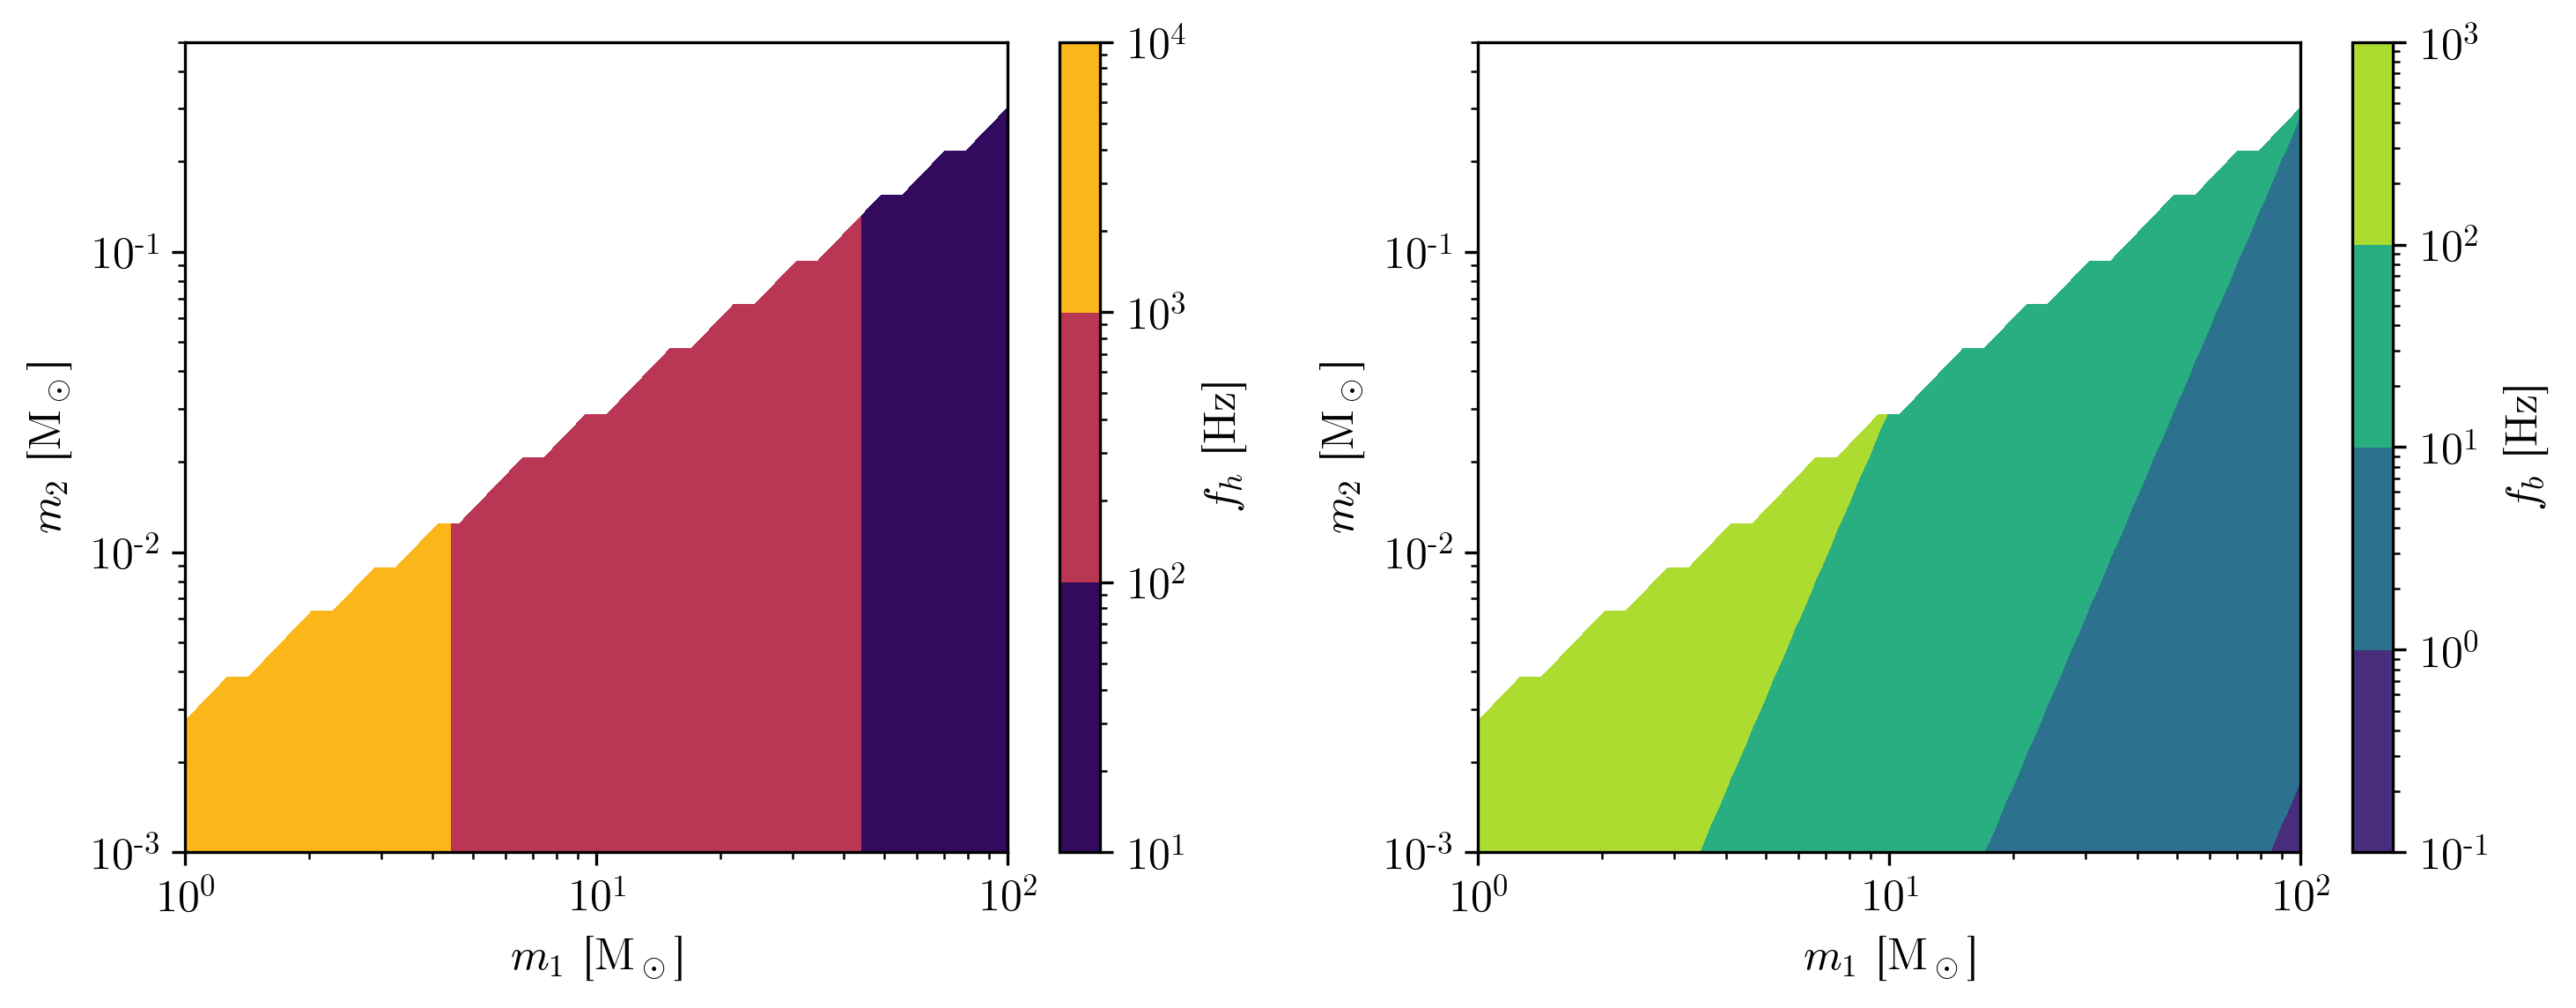

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["f_h"],
    locator=ticker.LogLocator(),
#     levels=jnp.geomspace(1e1, 1e4, 10),
    cmap="inferno",
)
plt.colorbar(cs, ax=ax, label=r"$f_h$ [Hz]")

ax = axes[1]
f_bs = jnp.vectorize(lambda m_1, m_2: get_f_b(m_1, m_2, gamma_s_pbh))(m_1_mg, m_2_mg)
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    f_bs * (m_2_mg / m_1_mg < 10**(-2.5)),
    locator=ticker.LogLocator(),
#     levels=jnp.geomspace(1e-1, 1e4, 11),
#     cmap="cividis",
)
plt.colorbar(cs, ax=ax, label=r"$f_b$ [Hz]")

for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$m_1$ [M$_\odot$]")
    ax.set_ylabel(r"$m_2$ [M$_\odot$]")

fig.tight_layout()

### Check whether fits are reliable or too unstable. They look pretty reasonable, even for quite large dephasings.

In [72]:
dd = make_dynamic_dress(40 * MSUN, 1e-2 * MSUN, rho_s_pbh, gamma_s_pbh, dL=120e6 * MSUN)


def fun(M_chirp_MSUN):
    vb = VacuumBinary(M_chirp_MSUN * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
    f_h = min(dd.f_c, f_range_et[1])
    return loglikelihood_fft(vb, dd, f_range_et[0], f_h, 100000, 1000, S_n_et)

bracket = (dd.M_chirp / MSUN * (1 - 1e-5), dd.M_chirp / MSUN * (1 + 5e-5))
M_chirp_MSUNs = jnp.linspace(*bracket, 200)
lls = jnp.array([fun(Mc) for Mc in M_chirp_MSUNs])

vb = VacuumBinary(
    M_chirp_MSUNs[jnp.argmax(lls)] * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c
)
f_l, f_h = f_range_et[0], min(f_range_et[1], dd.f_c)
print(
    "dN = ",
    (Phi_to_c(f_l, vb) - Phi_to_c(f_h, vb) - (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd)))
    / (2 * pi),
)

dN =  5020.112117056262


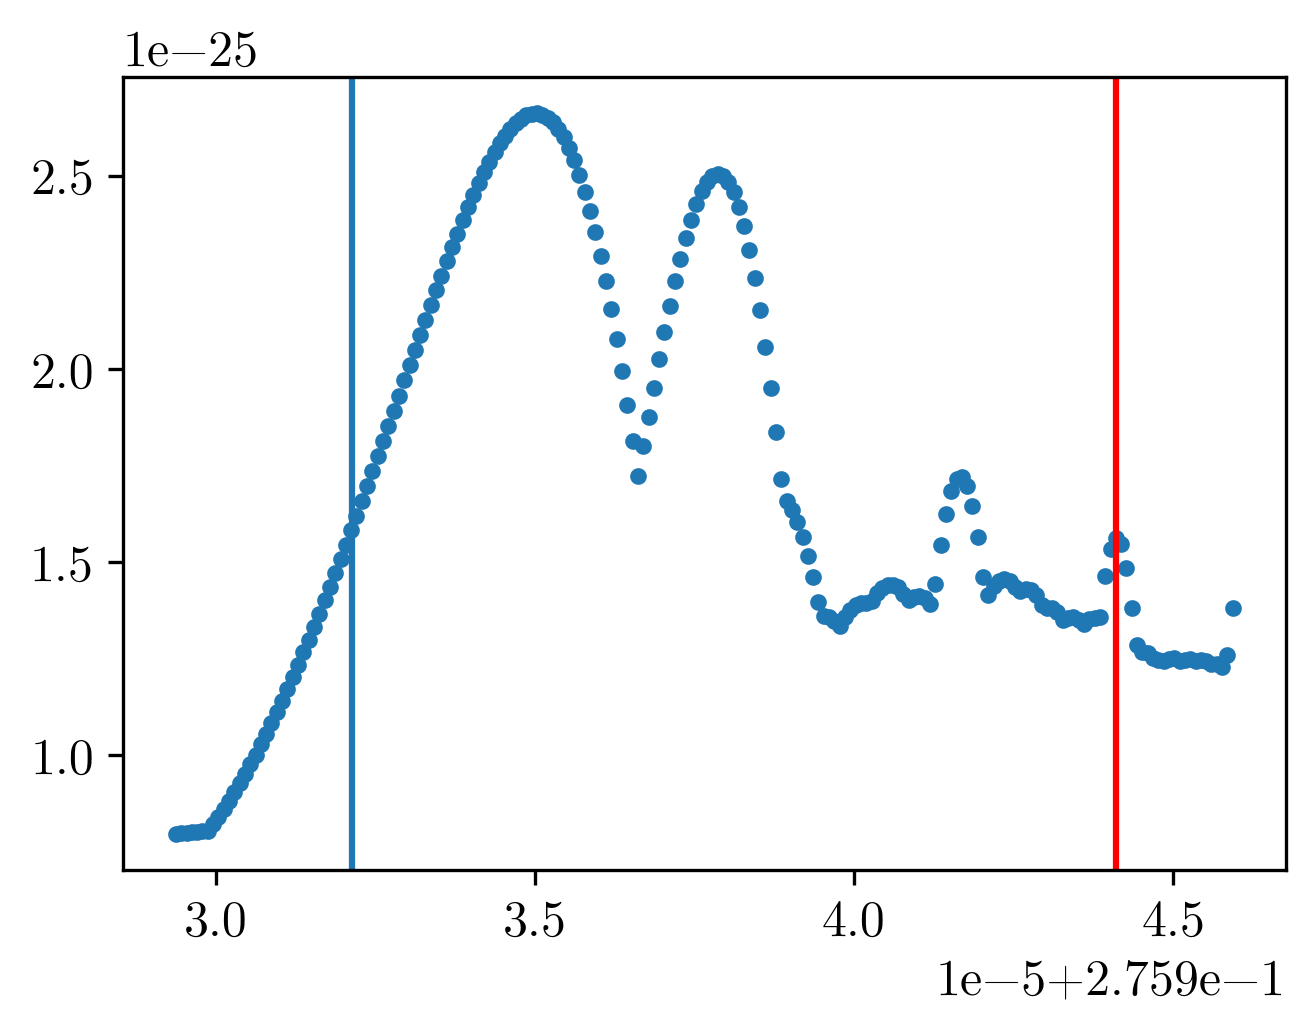

In [73]:
plt.plot(M_chirp_MSUNs, lls, ".")
plt.axvline(dd.M_chirp / MSUN)
plt.axvline(minimize_scalar(lambda x: -fun(x), bracket).x, color="r")

## Density normalization

In [105]:
def get_rho_6T(m_1, rho_s=1.798e4 * MSUN / PC ** 3):
    fun = lambda rho_6T: get_rho_s(rho_6T * 1e16 * MSUN / PC ** 3, m_1, 9 / 4) - rho_s
    return root_scalar(fun, bracket=(1e-6, 1e1)).root

Text(0.5, 1.0, 'PBH dress density normalization')

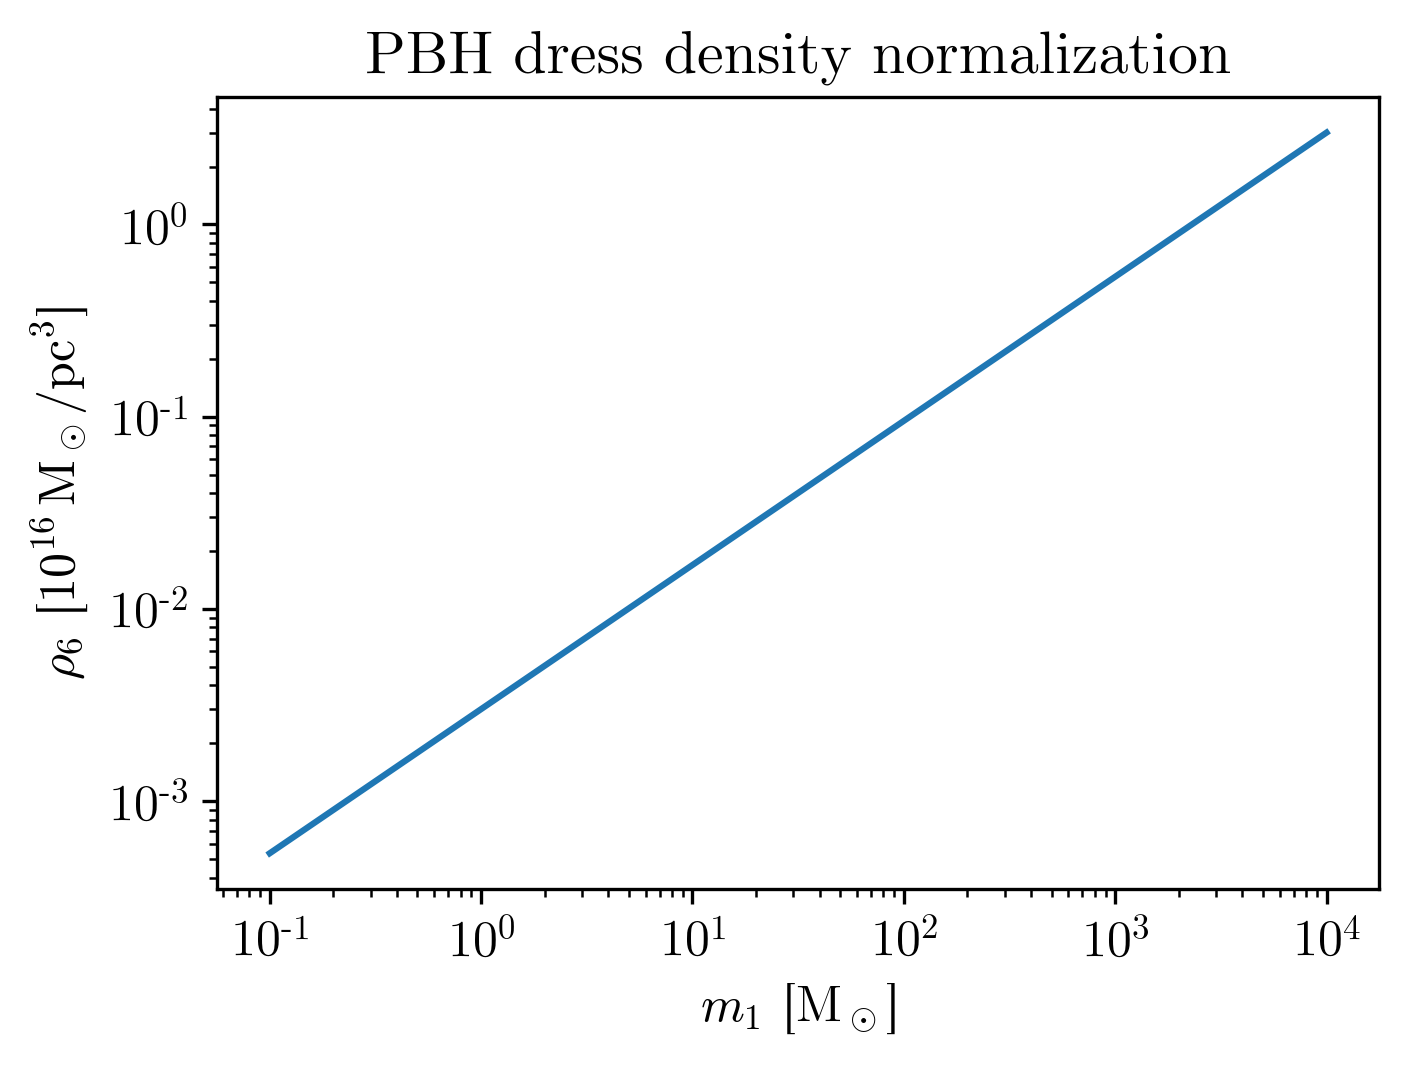

In [113]:
m_1s = jnp.geomspace(1e-1 * MSUN, 1e4 * MSUN, 100)

plt.loglog(m_1s / MSUN, list(map(get_rho_6T, m_1s)))
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$\rho_6$ [$10^{16} \, \mathrm{M}_\odot / \mathrm{pc}^3$]")
plt.title("PBH dress density normalization")

## Old

In [65]:
print("SNR = ", calculate_SNR(dd, f_l, dd.f_c, 3000, S_n))
print("dPhi (naive) = ", (Phi_to_c(f_l, vb_0) - Phi_to_c(f_l, dd)) / (2 * pi))

SNR =  14.991045811241946
Naive dephasing =  -5.229407663098171


Find best-fit vacuum system

In [14]:
dd = make_dynamic_dress(
    5 * MSUN, 5e-3 * MSUN, 1.798e4 * MSUN / PC ** 3, 9 / 4, dL=26e6 * PC
)
f_l = 20.0

In [69]:
def fun(x):
    vb = VacuumBinary(x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
    return -loglikelihood_fft(vb, dd, f_l, dd.f_c, 5000, 1000, S_n)


res = minimize_scalar(fun, bracket=(dd.M_chirp / MSUN, dd.M_chirp / MSUN + 1e-4), tol=1e-100)
assert res.success
vb = VacuumBinary(res.x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
print("p(h|s) = ", -res.fun)
print("p(s|s) = ", loglikelihood_fft(dd, dd, f_l, dd.f_c, 5000, 1000, S_n))
print("Dephasing = ", (Phi_to_c(f_l, vb) - Phi_to_c(f_l, dd)) / (2 * pi), " cycle")

p(h|s) =  71.7761575459551
p(s|s) =  112.47968507665817
Dephasing =  -1.215834026833111  cycle


Text(0, 0.5, 'Match integrand [s?]')

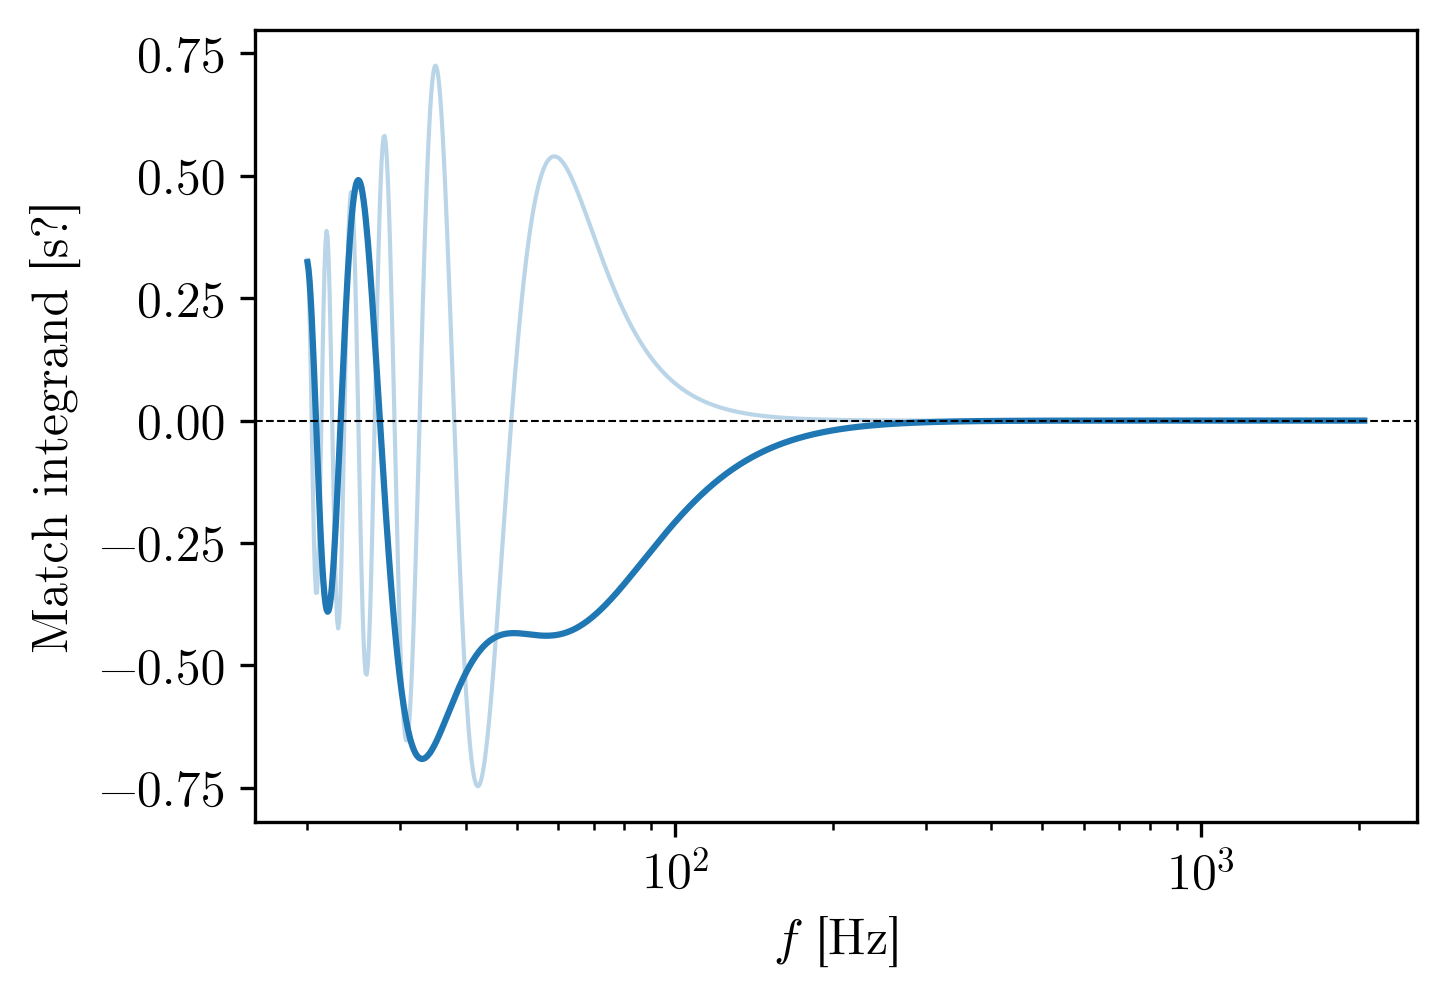

In [29]:
plt.semilogx(
    fs, amp(fs, vb) * amp(fs, dd) * jnp.sin(Phi_to_c(fs, vb) - Phi_to_c(fs, dd)) / S_n(fs)
)
# plt.semilogx(
#     fs, amp(fs, vb) * amp(fs, dd) * jnp.cos(Phi_to_c(fs, vb) - Phi_to_c(fs, dd)) / S_n(fs)
# )

plt.semilogx(
    fs,
    amp(fs, vb_0) * amp(fs, dd) * jnp.sin(Phi_to_c(fs, vb_0) - Phi_to_c(fs, dd)) / S_n(fs),
    "C0",
    alpha=0.3,
    linewidth=1
)
# plt.semilogx(
#     fs,
#     amp(fs, vb_0) * amp(fs, dd) * jnp.cos(Phi_to_c(fs, vb_0) - Phi_to_c(fs, dd)) / S_n(fs),
#     "C1",
#     alpha=0.3,
#     linewidth=1
# )

plt.axhline(0, linestyle="--", color="k", linewidth=0.5)
plt.xlabel(r"$f$ [Hz]")
plt.ylabel("Match integrand [s?]")